# Credit Card Default Prediction
___

DSCI 100 - Group 154: Eric Pien, Sydney Quach, Aryan Taneja, Kaila Villarey

## 1. Introduction
___

#### **Background** ####
Credit Cards are an essential part of our daily lives today. Per Statista, there were 76M credit cards in circulation within Canada. The great prevalence of credit cards in our society poses the risk of abused consumption and credit card defaults. Credit card default results when an individual does not pay at least the minimum of what they owe over six months. Large-scale credit card defaults have the potential to result in systemic failures of banks and broader capital markets. Thus, predicting the default status of credit card clients is essential for risk control to prevent a potential bank crisis.
 
#### **Previous Studies** ####

Previous studies have used diverse statistical analysis methods to develop models for credit scoring. For example, Giudici (2001) proposed computational Bayesian methods could be applied to data mining applications such as credit scoring. Bayesian analysis is a statistical inference that allows the combination of prior information about a population with evidence that becomes available to update the probability of a hypothesis. This approach allows consideration for model uncertainties, which is useful for the context of risk prediction. However, a major disadvantage of Bayesian analysis is that accuracy of predictions is highly correlated with class conditional independence and thus simplifies computation.
 
Another study by Lee et al. (2002) explored the combination of neural networks with discriminant analysis on the performance of credit scoring. A neural network refers to a series of algorithms that recognize relationships within a dataset. Discriminant analysis is a technique used to assign objects to a known group based on different variables. Using this combination approach for credit scoring, the accuracy of credit scoring improved and convergence characteristics were better overall. This combination method proved to be effective but future research aims to collect more variables to increase accuracy for applications such as risk prediction.
 
Altogether, previous studies have set the foundation for using statistical analysis for applications such as credit scoring. However, such statistical analysis is also useful to predict a credit card client’s default status and is therefore essential for risk control.

#### **Thesis** ####
Using the data and the techniques learned in class, we would like to answer the question: **can we predict the default status of a credit card client?**

#### **Data** ####
The data is from a debit and credit card issuing bank in Taiwan. The data consists of information about 30,000 customers as at October 2005, of which 23,364 (78%) have not defaulted while 6,636 (22%) have defaulted. The default status is represented as a binary variable (1 = Yes, 0 = No). 

Variables available to be used as direct inputs are as below:
* **X1**: Amount of Credit Given (NT\$)
* **X2**: Sex (1 = Male, 2 = Female)
* **X3**: Education (1 = Graduate School, 2 = University, 3 = High School, 4 = Others)
* **X4**: Marital Status (1 = Married, 2 = Single, 3 = Others)
* **X5**: Age (# of Years)
* **X6-X11**: Repayment Status (-1 = Prepaid, 0 = Clear, 1 = Payment Delay of 1 Month, 2 = Payment Delay of 2 Months, ..., 8 = Payment Delay of 8 Months, 9 = Payment Delay of 9 Months or greater)
    * **X6-11**  = 2005-09 to 2005-04
* **X12-X17**: Amount of Bill Statement (NT\$)
    * **X12-17** = 2005-09 to 2005-04
* **X18-X23**: Amount of Previous Payment (NT\$)
    * **X18-23** = 2005-09 to 2005-04

Source of Data: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

## 2. Methods & Results
___

### Section 2 Overview ###
**1. Load, Clean, Feature Engineering, Split**

* **Environment Setup**: We start by loading in all necessary packages

* **Read & Clean**: 
    1. **Read the table from GitHub**: Data was reaed with initial 30,000 observations as per data description.
    2. **Clean data to match data description**: Status range was shifted down from [-1,9] to [-2,8]. So shifted the data up by one.
    3. **Remove non-defined observations**: In few cases, martial status, sex, and education had undefined categories. Therefore, removed the unknown categories. This filtered down to 29,601 observations. 
    4. **Check for NAs and data's tidy-ness**: There were no NAs found in data so retained all 29,601 observations.
>
* **Feature Engineering**: We tested two new features based on the raw inputs.
    1. **balance_pct_0***n*: This feature is the % of credit limit drawn and shown as the balance on the given month over the credit limit. The feature assumes the credit limit has remained unchanged in the preceeding 6 months and that an individual's balance and credit limit at this specific bank account fully represents the person's ability to borrow money. The feature is calculated using the following formula:

        $\% \text{ Credit Drawn}_\text{t} = \frac{\text{Amount of Bill Statement}_\text{t}}{\text{Amount of Credit Given}}$


    2. **volatility**: This feature is the stadnard deviation of the month over month payment in the preceeding 6 months. The intuition here was that a person of lower credit quality would be consistently not paying or paying just the interest amount, while a consumer of higher credit quality would be paying differing monthly payment depending on the amount of credit spent that month. The feature is calculated using the following formula:
        
        $\sqrt{ \frac{1}{T} \sum \limits _{i=1} ^{T} {(\text{Payment}_t - \text{Average Payment})^2}}$ 
        
* **Split**: In our study, we split the data 75/25 to leave sufficient amount of data to test our model. 
>
>

**2. Data Exploration**
* **Baseline Performance Benchmark**: We calculate the baseline performance benchmark for the model within the training data as the % of the majority. In this case, 77.69% of the training data's observation was not defaulted so we use this number to measure the value-add of our model (**Table 3**).

* **Summary Tables: min, mean, median, max**: We estimate the sample statistics using different grouping to check of obvious issues and patterns with the data.
    * **Table 4**: Average age between default and non-default are similar at 35 years. On average, people that did not default had higher credit limit and slightly higher balance on the last month.
    * **Table 5**: The data consists of more female than male. Average age, credit limit, and balance amount is not that different.
    * **Table 6**: Over 47% of the training data have undergraduate level of study. Another 30% have graduate level education. Credit limit tends to increase with education level exluding "other" category.
    * **Table 7**: The data is evenly split between married and not-married. Both credit limit and average balance on the last month increase on average for married customers.
    * **Table 8**: 50% of the data is 1 month behind on their payment while 27% are either fully paid or pre-paid. On average, customers of greater delay have lower credit limit.
    * **Table 9**: In both default and non-default population, there is similar minimum credit limit and age, but the non-default have higher maximum credit limit and age. On average, non-default had lower balance as % of credit limit on the last month and exhibited higher month over month payment volatiity.
>
>
* **Charts**: We visualize certain data that are best represented in chart format.
    * **Figure 1**: Pair-plot of non-categorical values to find general relationship between numerical values.
    * **Figure 2**: Male population had higher default rate across education level, and marital status.
    * **Figure 3**: Not-defaulted customers are more likely to have higher volatility in payment history and higher % of credit drawn.
    * **Figure 4/5**: While age is not a good predictor for default status, credit limit is a good indicator showing the higher the credit limit, the less likely the customer to default.
    
>
>

**3. Model Fitting and Testing**
* **Model 1 (Categorical feature only)**: This model consists only of the categorical variables.
* **Model 2 (Engineered feature only)**: This model consists of only the variables that were engineered out of the raw inputs.
* **Model 3 (Manually-selected features)**: This model consinsts of variables that have shown to be additive to the model's predictive power.
    * **Figure 6**: Performance comparison of the three models created using overlaid elbow charts. (discussed further in Section 3. Discussion.)
    
>
>

**4. Final Model Selection and Test**
* **Model Selection**: We select the best performing model - the Model 1.
* **Test**: Predictive power falls slightly from just the training set but still exceeds that of the baseline performance benchmark.
    * **Table 11/ Figure 7**: The model overestimates the number of customers that will not default. (discussed further in Section 3. Discussion.)

### 2.1 Load, Clean, Split ###

#### Environment Setup

In [240]:
# Environment Setup
library(tidyverse)
library(tidymodels)
library(GGally)
library(gridExtra)
library(recipes)
library(kknn)
library(themis)
library(cowplot)

#table and figure #s for labels
table_n = 0
figure_n = 0

#### Read & Clean

In [215]:
# Specify column names to make it easier to work with
columns = c('id', 'credit_limit', 'sex', 'education', 'marital_status', 'age',
            'status_09', 'status_08', 'status_07', 'status_06', 'status_05', 'status_04',
            'balance_09', 'balance_08', 'balance_07', 'balance_06', 'balance_05', 'balance_04',
            'payment_09', 'payment_08', 'payment_07', 'payment_06', 'payment_05', 'payment_04',
            'y')
            
# Read from the web into R
credit_card_data <- read_csv('https://raw.githubusercontent.com/ericpien/dsci-100-group-154/main/data/default%20of%20credit%20card%20clients.csv',skip=2,col_names=columns) |>
    select(-id)

# Clean Data and rid of any non-defined observations
credit_card_data <- credit_card_data |>
    mutate(status_09 = status_09+1,
        status_08 = status_08+1,
        status_07 = status_07+1,
        status_06 = status_06+1,
        status_05 = status_05+1,
        status_04 = status_04+1) |>
    filter(marital_status %in% c(1,2,3)) |>
    filter(sex %in% c(1,2)) |>
    filter(education %in% c(1,2,3,4))

# convert variables to factors    
credit_card_data <- credit_card_data |>
    mutate(y = as_factor (y),
            sex = as_factor(sex),
            education = as_factor(education),
            marital_status = as_factor(marital_status),
            status_09 = as_factor(status_09),
            status_08 = as_factor(status_08),
            status_07 = as_factor(status_07),
            status_06 = as_factor(status_06),
            status_05 = as_factor(status_05),
            status_04 = as_factor(status_04))

# Check for NA Data
na_data_count <- sapply(credit_card_data,function(x) sum(is.na(x))) |>
    t() |>
    as_tibble()

Rows: 30000 Columns: 25
-- Column specification --------------------------------------------------------
Delimiter: ","
dbl (25): id, credit_limit, sex, education, marital_status, age, status_09, ...

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [216]:
print(paste0('Table ', table_n <- table_n + 1))
na_data_count

print(paste0('Table ', table_n <- table_n + 1))
# Check the data is pre-loaded in tidy format
head(credit_card_data)

[1] "Table 1"


credit_limit,sex,education,marital_status,age,status_09,status_08,status_07,status_06,status_05,⋯,balance_06,balance_05,balance_04,payment_09,payment_08,payment_07,payment_06,payment_05,payment_04,y
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


[1] "Table 2"


credit_limit,sex,education,marital_status,age,status_09,status_08,status_07,status_06,status_05,⋯,balance_06,balance_05,balance_04,payment_09,payment_08,payment_07,payment_06,payment_05,payment_04,y
<dbl>,<fct>,<fct>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
20000,2,2,1,24,3,3,0,0,-1,⋯,0,0,0,0,689,0,0,0,0,1
120000,2,2,2,26,0,3,1,1,1,⋯,3272,3455,3261,0,1000,1000,1000,0,2000,1
90000,2,2,2,34,1,1,1,1,1,⋯,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
50000,2,2,1,37,1,1,1,1,1,⋯,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
50000,1,2,1,57,0,1,0,1,1,⋯,20940,19146,19131,2000,36681,10000,9000,689,679,0
50000,1,1,2,37,1,1,1,1,1,⋯,19394,19619,20024,2500,1815,657,1000,1000,800,0


#### Feature Engineering

In [217]:
# Feature Engineering
credit_card_data <- credit_card_data |>
                    mutate(balance_pct_09 = balance_09 / credit_limit) |>
                    mutate(balance_pct_08 = balance_08 / credit_limit) |>
                    mutate(balance_pct_07 = balance_07 / credit_limit) |>
                    mutate(balance_pct_06 = balance_06 / credit_limit) |>
                    mutate(balance_pct_05 = balance_05 / credit_limit) |>
                    mutate(balance_pct_04 = balance_04 / credit_limit)

credit_card_data <- credit_card_data |> 
                    mutate(payment_mean = (payment_09 + payment_08 + payment_07 + payment_06 + payment_05 + payment_04)/6 ) |>
                    mutate(volatility = sqrt(((payment_09 - payment_mean)^2 +
                                              (payment_08 - payment_mean)^2 +
                                              (payment_07 - payment_mean)^2 +
                                              (payment_06 - payment_mean)^2 +
                                              (payment_05 - payment_mean)^2 +
                                              (payment_04 - payment_mean)^2) / 6))

#### Split

In [218]:
# Split
set.seed(154)
credit_card_split <- credit_card_data |> initial_split(prop=0.75, strata = y)
credit_card_train <- training(credit_card_split)
credit_card_test <- testing(credit_card_split)

### 2.2 Data Exploration ###

#### Baseline Performance Benchmark ###

In [219]:
# Setting up Baseline
print(paste0('Table ', table_n <- table_n + 1))

credit_card_train |>
    group_by(y) |>
    summarize(default_count=n())|>
    mutate(default_pct = default_count/sum(default_count))

[1] "Table 3"


y,default_count,default_pct
<fct>,<int>,<dbl>
0,17247,0.7768919
1,4953,0.2231081


#### Summary Tables

In [220]:
# Summarize the data - count and average demographic profile of clients by default and non-default status
print(paste0('Table ', table_n <- table_n + 1))

credit_card_train |>
    group_by(y) |>
    summarize(count=n(),
            average_age = mean(age),
            average_credit_limit = mean(credit_limit),
            average_balance_09 = mean(balance_09),
            average_balance_09 = mean(balance_09))

[1] "Table 4"


y,count,average_age,average_credit_limit,average_balance_09
<fct>,<int>,<dbl>,<dbl>,<dbl>
0,17247,35.39015,178142.6,52382.82
1,4953,35.64527,131515.8,47883.55


In [221]:
# Summarize the data - count and average demographic profile of clients by sex
print(paste0('Table ', table_n <- table_n + 1))

credit_card_train |>
    group_by(sex) |>
    summarize(count=n(),
            average_age = mean(age),
            average_credit_limit = mean(credit_limit),
            average_balance_09 = mean(balance_09),
            average_balance_09 = mean(balance_09))

[1] "Table 5"


sex,count,average_age,average_credit_limit,average_balance_09
<fct>,<int>,<dbl>,<dbl>,<dbl>
1,8808,36.48899,164417.3,54876.21
2,13392,34.76180,169925.0,49078.85


In [222]:
# Summarize the data - count and average demographic profile of clients by education
print(paste0('Table ', table_n <- table_n + 1))

credit_card_train |>
    group_by(education) |>
    summarize(count=n(),
            average_age = mean(age),
            average_credit_limit = mean(credit_limit),
            average_balance_09 = mean(balance_09),
            average_balance_09 = mean(balance_09))

[1] "Table 6"


education,count,average_age,average_credit_limit,average_balance_09
<fct>,<int>,<dbl>,<dbl>,<dbl>
1,7885,34.20812,213247.9,49532.46
2,10604,34.72105,147226.1,53711.06
3,3624,40.30298,127339.3,48303.86
4,87,33.95402,226436.8,62585.16


In [223]:
# Summarize the data - count and average demographic profile of clients by marital status
print(paste0('Table ', table_n <- table_n + 1))

credit_card_train |>
    group_by(marital_status) |>
    summarize(count=n(),
            average_age = mean(age),
            average_credit_limit = mean(credit_limit),
            average_balance_09 = mean(balance_09),
            average_balance_09 = mean(balance_09))

[1] "Table 7"


marital_status,count,average_age,average_credit_limit,average_balance_09
<fct>,<int>,<dbl>,<dbl>,<dbl>
1,10119,39.96680,183160.98,53308.12
2,11834,31.42488,156069.60,49915.76
3,247,42.99190,95101.21,42452.24


In [224]:
# Summarize the data - count and average demographic profile of clients by payment status
print(paste0('Table ', table_n <- table_n + 1))

credit_card_train |>
    group_by(status_09) |>
    summarize(count=n(),
            average_age = mean(age),
            average_credit_limit = mean(credit_limit),
            average_balance_09 = mean(balance_09),
            average_balance_09 = mean(balance_09))

[1] "Table 8"


status_09,count,average_age,average_credit_limit,average_balance_09
<fct>,<int>,<dbl>,<dbl>,<dbl>
-1,2034,36.98722,250255.65,8443.311
0,4147,36.19918,208314.44,10451.482
1,10980,34.91867,154285.76,78091.323
2,2752,35.34121,149138.81,27651.698
3,1947,35.36466,111543.91,65841.426
4,233,35.42918,85021.46,39023.399
5,57,35.24561,78771.93,67193.930
6,18,35.11111,84444.44,100966.444
7,9,36.11111,84444.44,85770.778


#### Summary of Numericial Columns ###

In [225]:
# Summarize the data - Min, Mean, Median, and Max of the numerical columns by default status (y)
print(paste0('Table ', table_n <- table_n + 1))

numeric_cols_train <- credit_card_train |>
    select(-sex, -education, -marital_status, -status_09, -status_08, -status_07, -status_06, -status_05, -status_04) |>
    mutate(y = as.numeric(y)-1)

min_0 <- apply(filter(numeric_cols_train, y == 0), 2, min, na.rm = TRUE)
average_0 <- apply(filter(numeric_cols_train, y == 0), 2,  mean, na.rm = TRUE)
median_0 <- apply(filter(numeric_cols_train, y == 0), 2, median, na.rm = TRUE)
max_0 <- apply(filter(numeric_cols_train, y == 0), 2, max, na.rm = TRUE)
min_1 <- apply(filter(numeric_cols_train, y == 1), 2, min, na.rm = TRUE)
average_1 <- apply(filter(numeric_cols_train, y == 1), 2, mean, na.rm = TRUE)
median_1 <- apply(filter(numeric_cols_train, y == 1), 2, median, na.rm = TRUE)
max_1 <- apply(filter(numeric_cols_train, y == 1), 2, max, na.rm = TRUE)

numeric_cols_summary <- rbind(min_0, average_0, median_0, max_0, min_1, average_1, median_1, max_1) |>
    as_tibble() |>
    mutate(info = c('Min','Mean','Median','Max','Min','Mean','Median','Max')) |>
    relocate(y,.before=credit_limit) |>
    relocate(info,.before=credit_limit)

numeric_cols_summary

[1] "Table 9"


y,info,credit_limit,age,balance_09,balance_08,balance_07,balance_06,balance_05,balance_04,⋯,payment_05,payment_04,balance_pct_09,balance_pct_08,balance_pct_07,balance_pct_06,balance_pct_05,balance_pct_04,payment_mean,volatility
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,Min,10000.0,21.00000,-15308.00,-67526.00,-157264.00,-170000.00,-81334.00,-209051.00,⋯,0.000,0.000,-0.2309000,-0.9646571,-0.9250824,-1.3745000,-0.8767429,-0.7208655,0.000,0.000
0,Mean,178142.6,35.39015,52382.82,50110.76,47903.33,43961.13,40994.48,39694.07,⋯,5255.274,5690.534,0.4078347,0.3931030,0.3730838,0.3391246,0.3134855,0.2994433,5828.881,5835.919
0,Median,150000.0,34.00000,23900.00,22441.00,20694.00,19262.00,18258.00,17159.00,⋯,1829.000,1740.000,0.2739667,0.2600385,0.2330000,0.2039821,0.1834476,0.1602200,2787.000,1409.675
0,Max,1000000.0,79.00000,964511.00,983931.00,1664089.00,891586.00,927171.00,961664.00,⋯,426529.000,528666.000,6.4553000,6.3805000,10.6885750,5.1468500,4.9355000,3.8855500,627344.333,593455.875
1,Min,10000.0,21.00000,-6029.00,-9119.00,-61506.00,-65167.00,-53007.00,-339603.00,⋯,0.000,0.000,-0.1000000,-0.2989000,-1.0251000,-1.0433000,-0.7500000,-1.2128679,0.000,0.000
1,Mean,131515.8,35.64527,47883.55,46779.31,44618.47,41600.41,39327.82,38206.65,⋯,3345.432,3568.310,0.4828527,0.4795797,0.4619709,0.4328327,0.4064043,0.3950048,3356.980,3426.126
1,Median,90000.0,34.00000,20214.00,20358.00,19783.00,19068.00,18283.00,17932.00,⋯,1000.000,1000.000,0.4753000,0.4739000,0.4458333,0.3945286,0.3647455,0.3443000,1585.833,1071.105
1,Max,740000.0,73.00000,613860.00,581775.00,572677.00,541019.00,547880.00,498316.00,⋯,332000.000,345293.000,3.6099250,3.6981000,3.4760500,2.7982400,2.7320800,2.6941000,117368.000,153588.184


#### Visualization ####

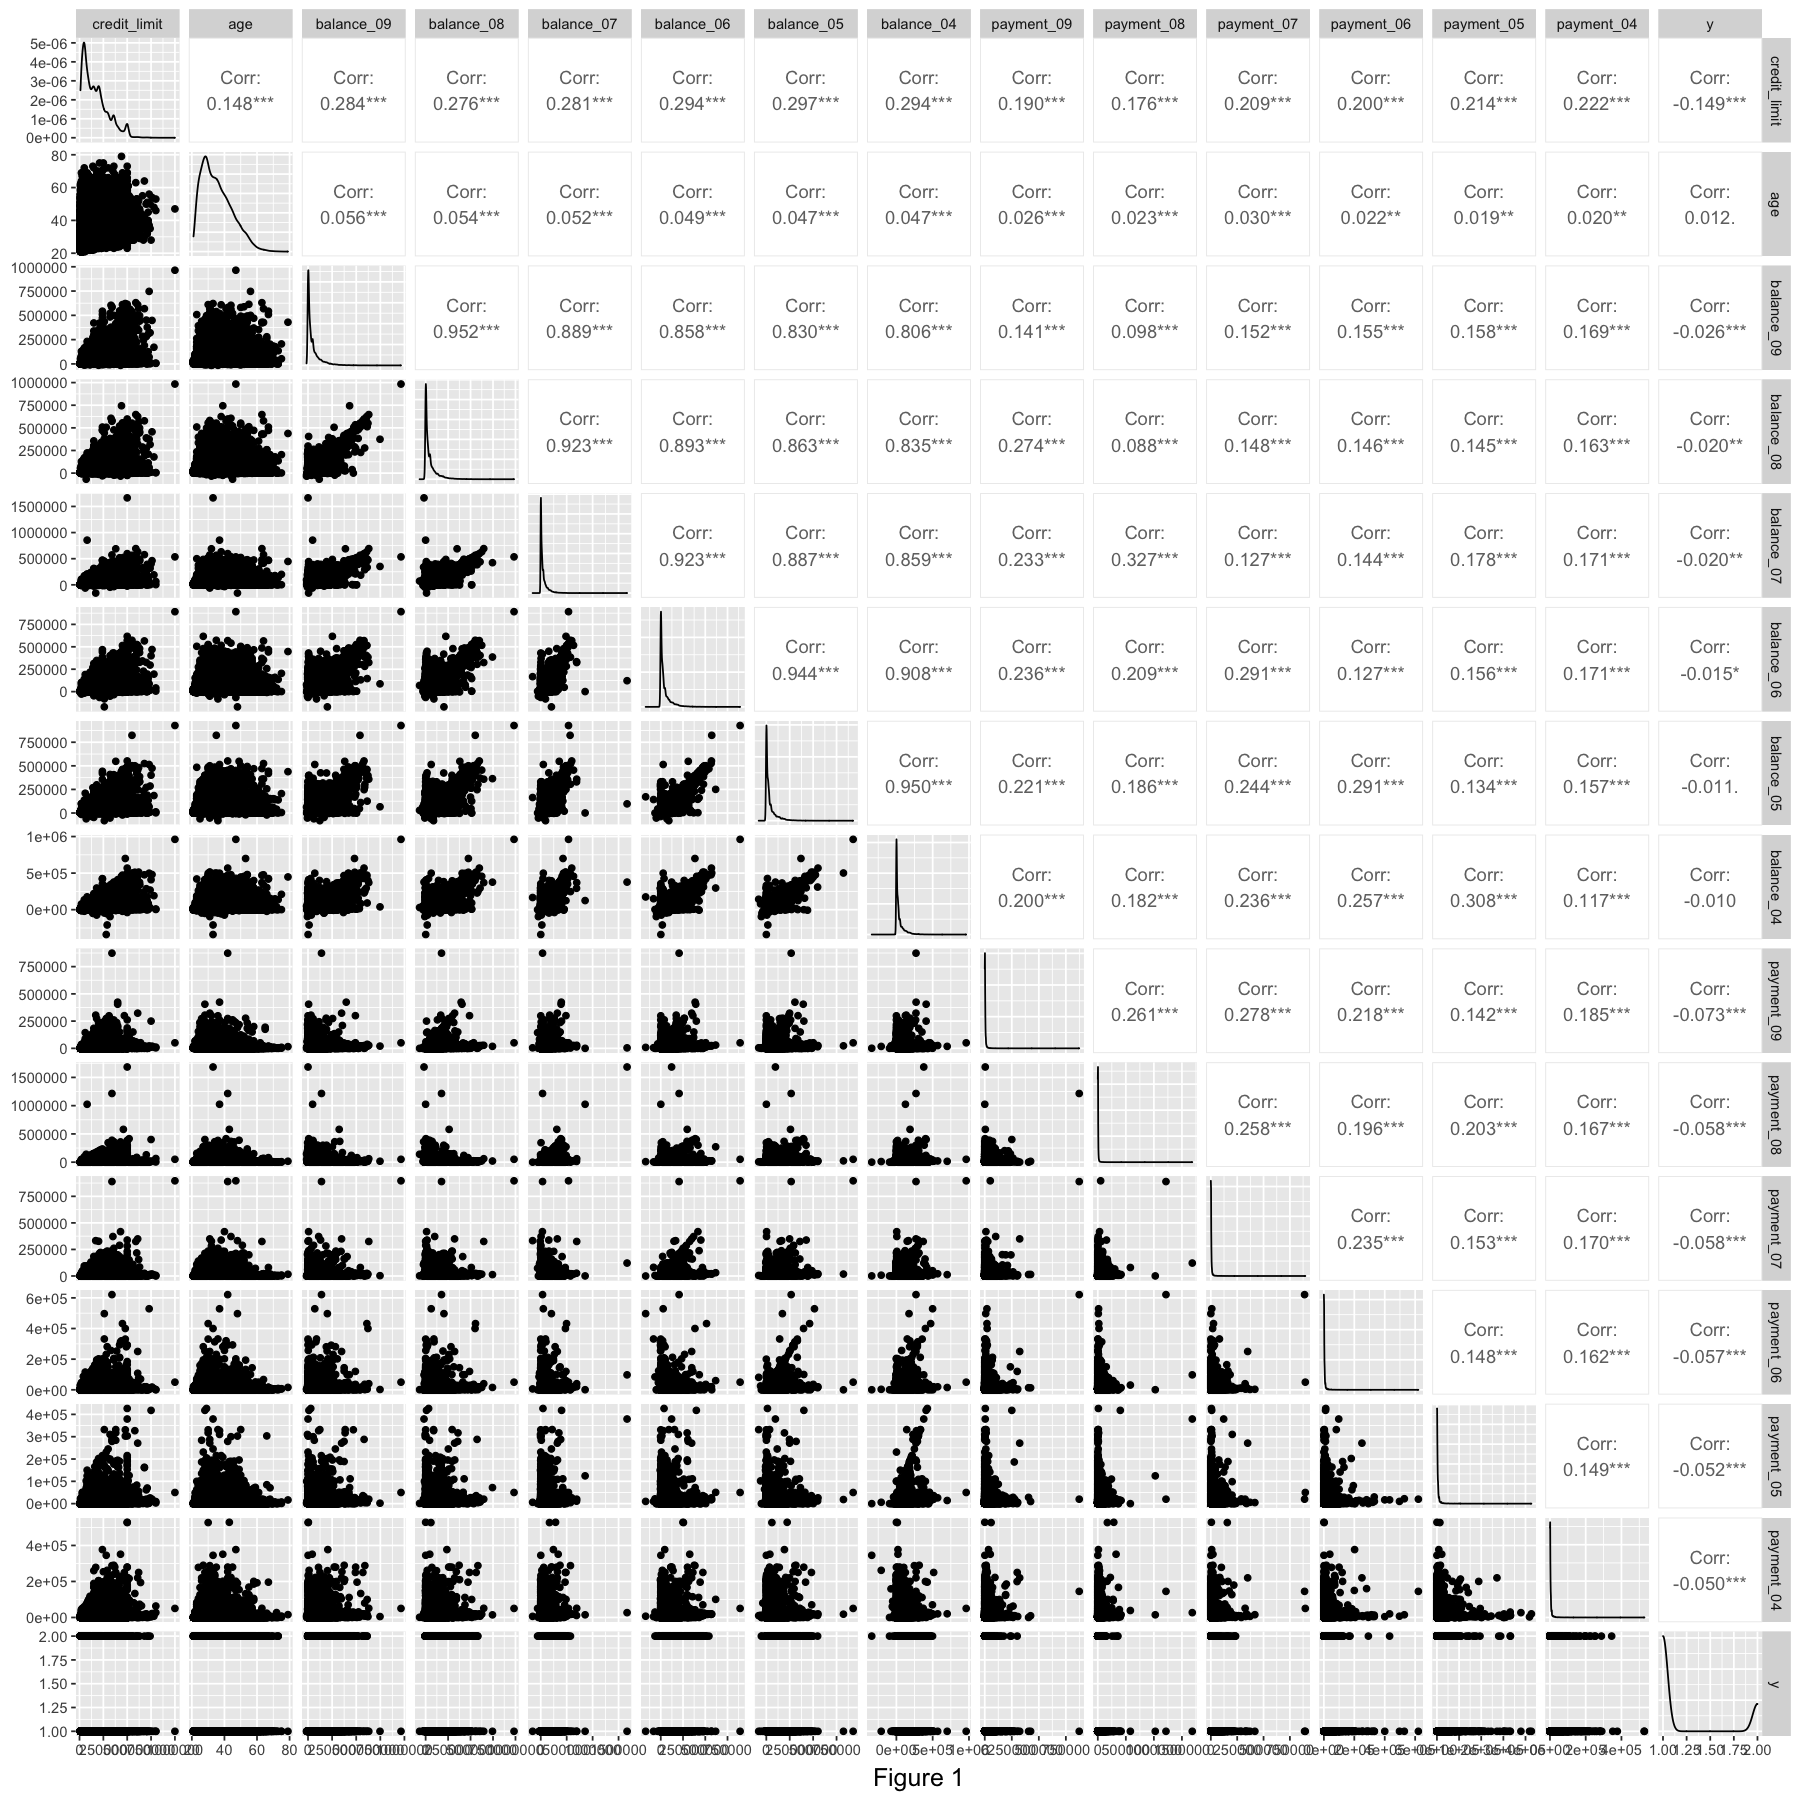

In [241]:
options(repr.plot.width = 15, repr.plot.height = 15)

credit_card_train |> 
    select(-sex, -education, -marital_status, -status_09, -status_08, -status_07, -status_06, -status_05, -status_04,
            -balance_pct_09, -balance_pct_08, -balance_pct_07, -balance_pct_06, -balance_pct_05, -balance_pct_04,
            -payment_mean, -volatility) |>
    mutate (y = as.numeric(y))|>
    ggpairs() + 
    labs(caption = paste0('Figure ', figure_n <- figure_n + 1)) +
    theme(plot.caption =  element_text(size=15,hjust=0.5))

`summarise()` has grouped output by 'sex', 'education'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'sex', 'marital_status'. You can override
using the `.groups` argument.


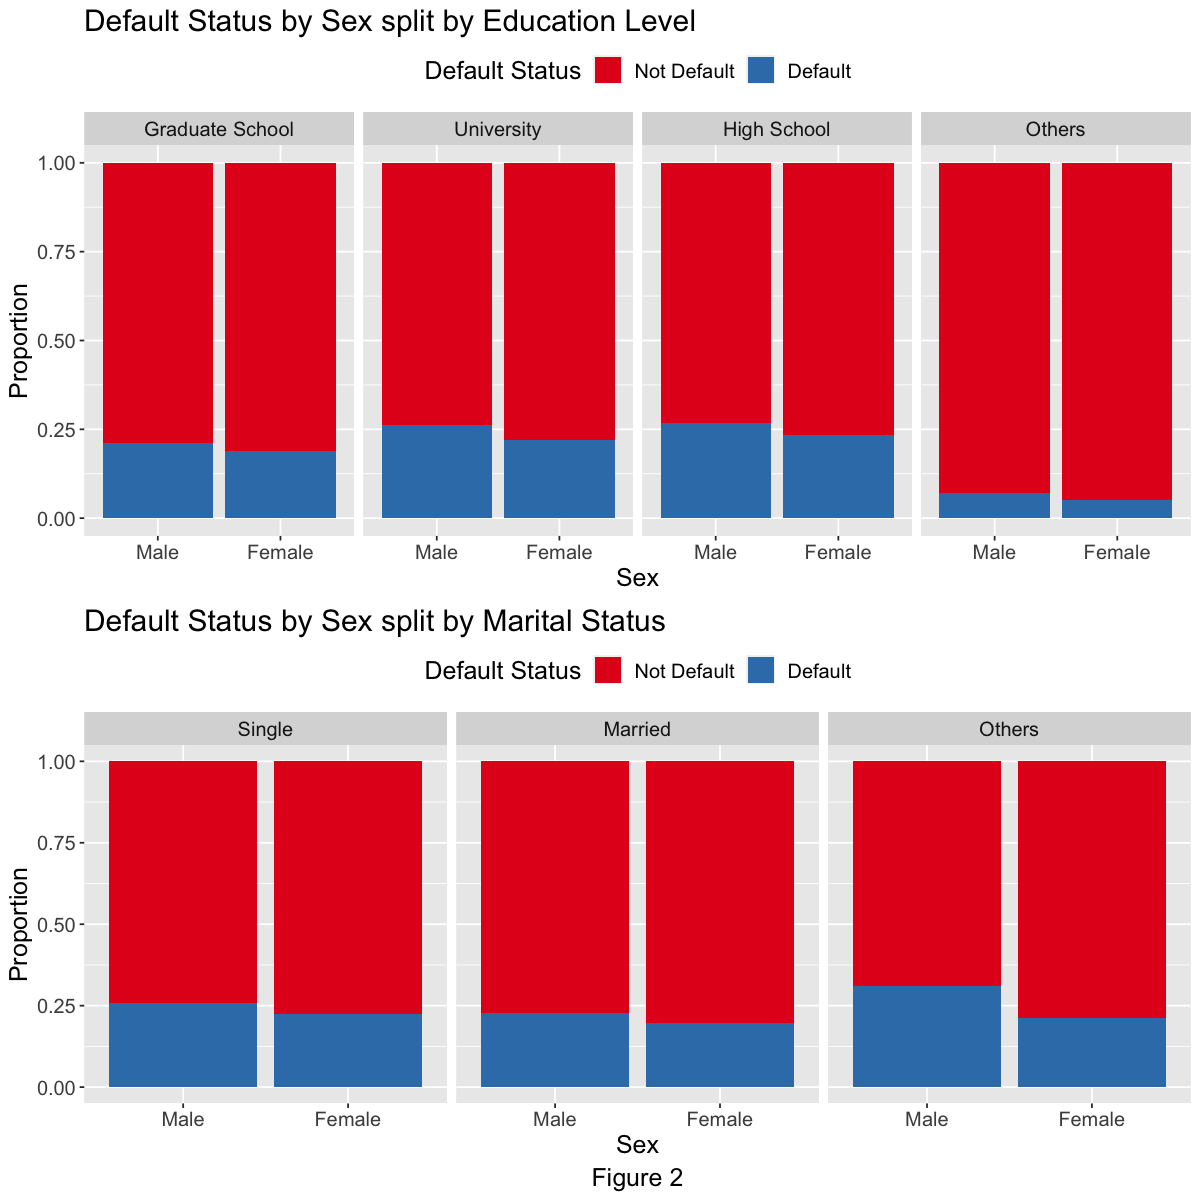

In [242]:
# Proportion of Default Status by Sex split by Education level and Marital Status
options(repr.plot.width = 10, repr.plot.height = 10) 

default_vs_sex_edu <- credit_card_train |>
    group_by(sex, education, y) |>
    summarise(n=n()) |>
    ggplot(aes(x=as_factor(sex),y=n,fill=as_factor(y))) +
    geom_bar(stat="identity",position="fill") +
    facet_wrap(~ education,ncol=4, labeller = labeller(
        education = c("1" = "Graduate School", "2" = "University", "3" = "High School", "4" = "Others"))) +
    scale_x_discrete(labels = c("1"="Male","2"="Female")) +
    scale_fill_brewer(labels = c('Not Default','Default'),palette = "Set1") +
    labs(x = "Sex"
        ,y = "Proportion"
        ,fill = "Default Status"
        ,title= "Default Status by Sex split by Education Level") +
    theme(text = element_text(size=15),legend.position = "top")

default_vs_sex_mar <- credit_card_train |>
    group_by(sex, marital_status, y) |>
    summarise(n=n()) |>
    ggplot(aes(x=as_factor(sex),y=n,fill=as_factor(y))) +
    geom_bar(stat="identity",position="fill") +
    facet_wrap(~ marital_status,ncol=4, labeller = labeller(
        marital_status = c("1" = "Single", "2" = "Married", "3" = "Others"))) +
    scale_fill_brewer(labels = c('Not Default','Default'),palette = "Set1") +
    scale_x_discrete(labels = c("1"="Male","2"="Female")) +
    labs(x = "Sex"
        ,y = "Proportion"
        ,fill = "Default Status"
        ,title= "Default Status by Sex split by Marital Status"
        ,caption = paste0('Figure ', figure_n <- figure_n + 1)) +
    theme(text = element_text(size=15),
        plot.caption =  element_text(size=15,hjust=0.5),
        legend.position = "top")

grid.arrange(default_vs_sex_edu,default_vs_sex_mar)

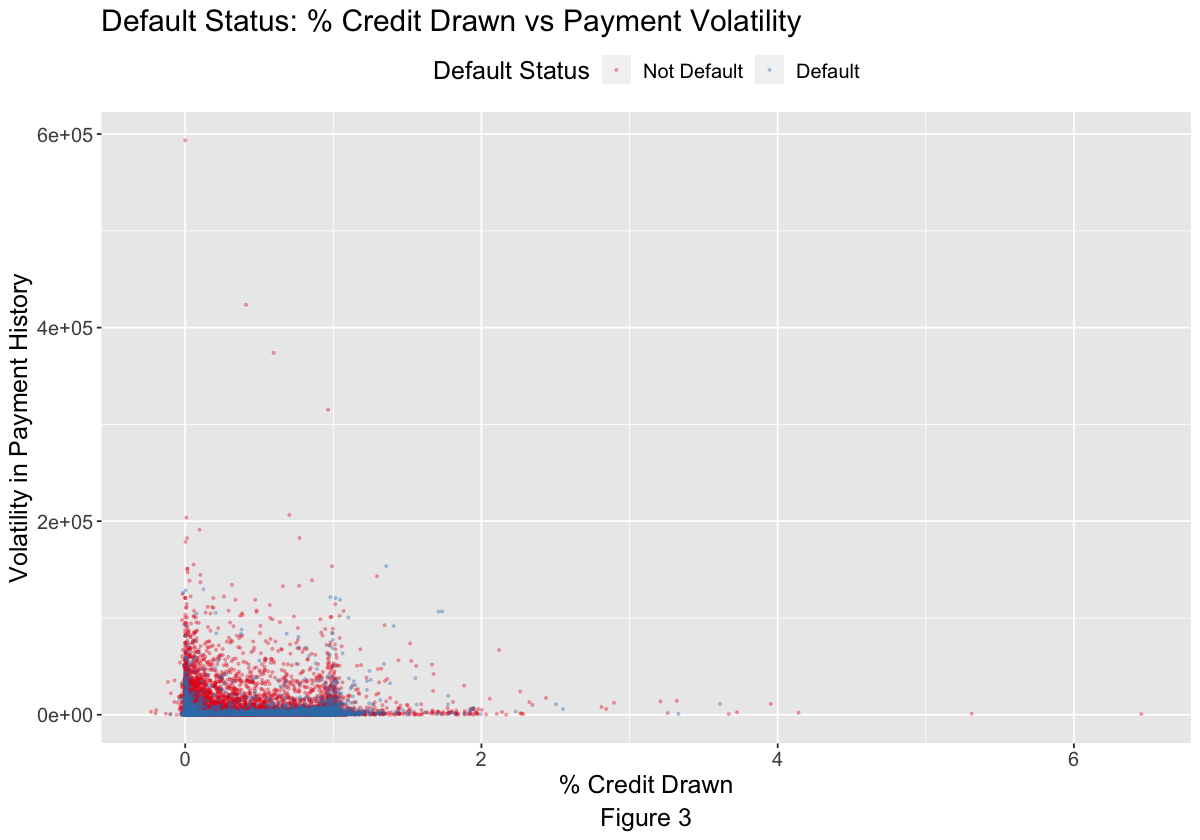

In [243]:
# Scatterplot of default status by credit limit and age
options(repr.plot.width = 10, repr.plot.height = 7) 

age_vs_credit_limit <- credit_card_train |>
    ggplot(aes(x=balance_pct_09,y=volatility, color=as_factor(y))) +
    geom_point(alpha=0.3, size = 0.5) +
    scale_color_brewer(labels = c('Not Default','Default'),palette = "Set1") +
    scale_x_continuous(labels = comma) +
    labs(x="% Credit Drawn"
        , y="Volatility in Payment History"
        , color = "Default Status"
        , title= "Default Status: % Credit Drawn vs Payment Volatility"
        , caption = paste0('Figure ', figure_n <- figure_n + 1)) +
    theme(text = element_text(size=15),
        legend.position = "top",
        plot.caption =  element_text(size=15,hjust=0.5))

age_vs_credit_limit

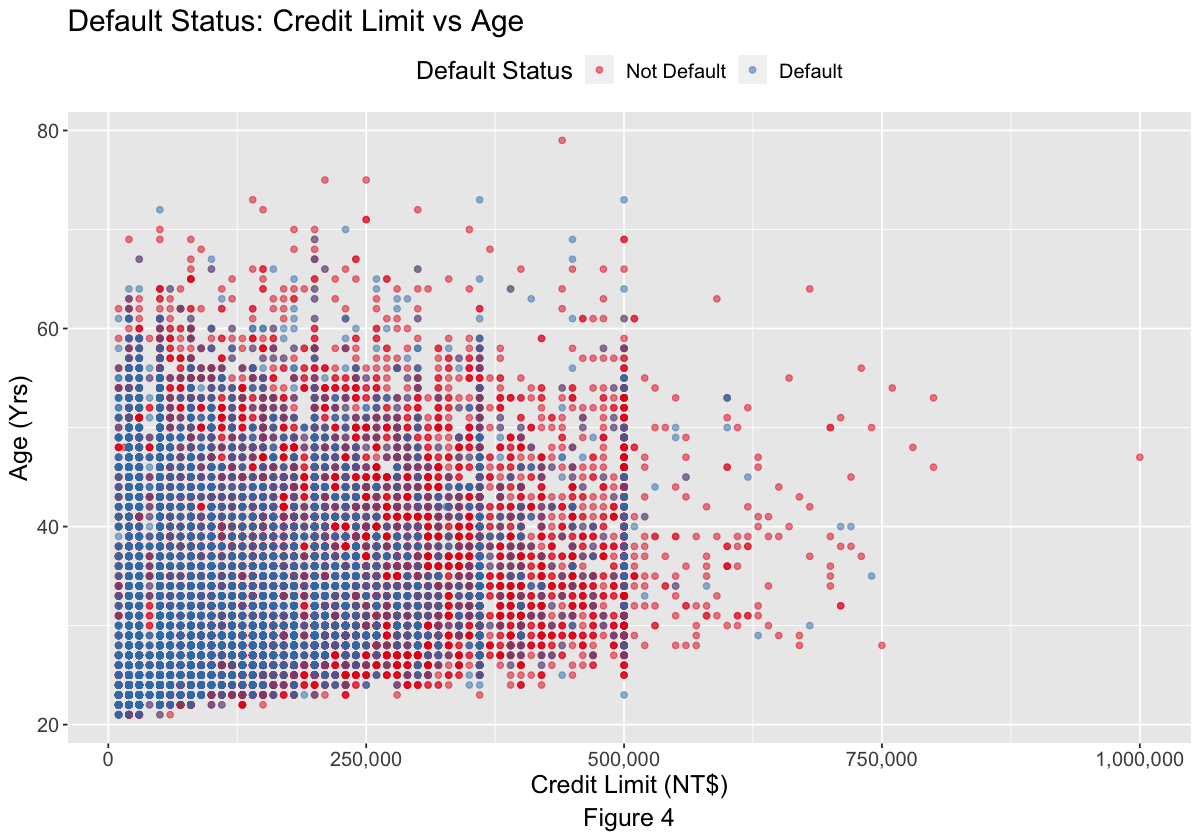

In [244]:
# Scatterplot of default status by credit limit and age
options(repr.plot.width = 10, repr.plot.height = 7) 

age_vs_credit_limit <- credit_card_train |>
    ggplot(aes(x=credit_limit,y=age, color=as_factor(y))) +
    geom_point(alpha=0.5) +
    scale_color_brewer(labels = c('Not Default','Default'),palette = "Set1") +
    scale_x_continuous(labels = comma) +
    labs(x="Credit Limit (NT$)"
        , y="Age (Yrs)"
        , color = "Default Status"
        , title= "Default Status: Credit Limit vs Age",
        ,caption = paste0('Figure ', figure_n <- figure_n + 1)) +
    theme(text = element_text(size=15),
        legend.position = "top",
        plot.caption =  element_text(size=15,hjust=0.5))

age_vs_credit_limit

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



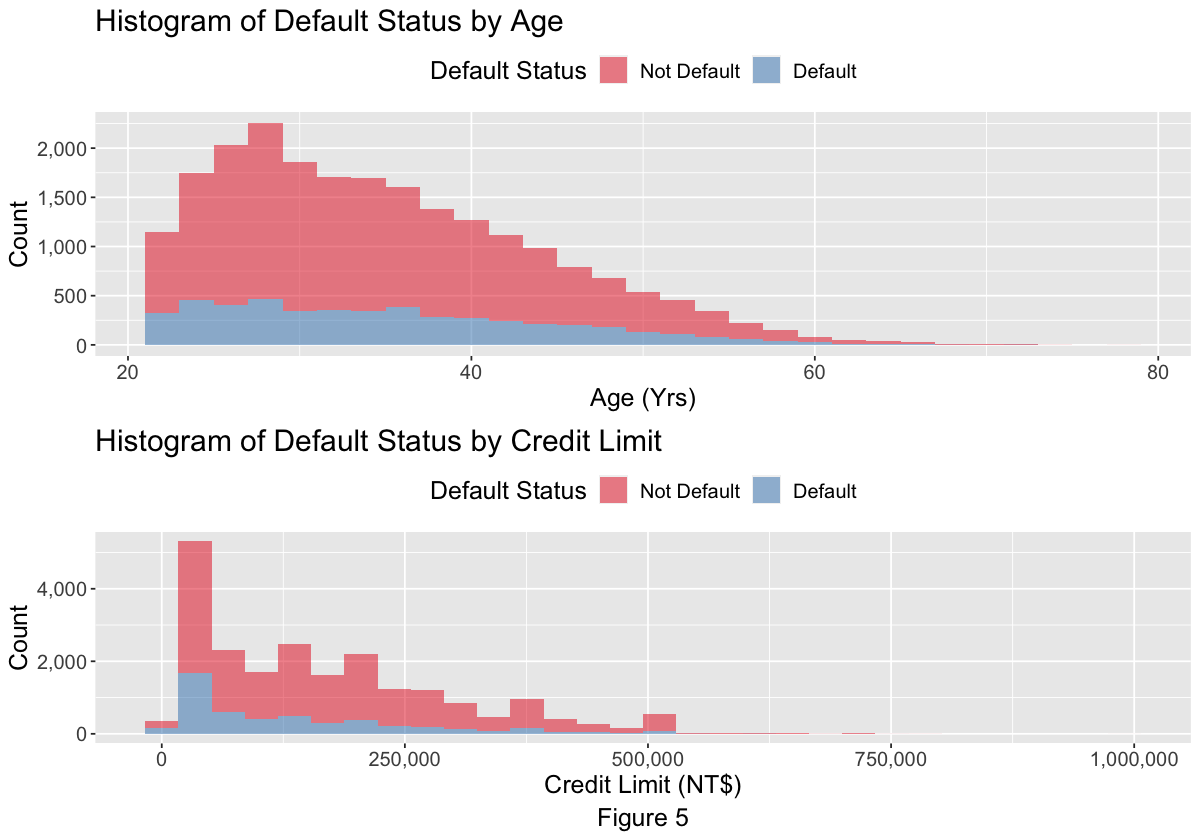

In [245]:
# Histogram of default status by credit limit and age
options(repr.plot.width = 10, repr.plot.height = 7) 

density_plot_age <- credit_card_train |>
    ggplot()+
    geom_histogram(aes(x=age, fill = as_factor(y)),alpha=0.5)+
    scale_fill_brewer(labels = c('Not Default','Default'),palette = "Set1")+
    scale_x_continuous(labels = comma)+
    scale_y_continuous(labels = comma)+
    labs(x="Age (Yrs)"
        , y="Count"
        , fill="Default Status"
        , title="Histogram of Default Status by Age")+
    theme(text = element_text(size=15),legend.position = "top")


density_plot_credit_limit <- credit_card_train |>
    ggplot()+
    geom_histogram(aes(x=credit_limit, fill = as_factor(y)),alpha=0.5)+
    scale_fill_brewer(labels = c('Not Default','Default'),palette = "Set1")+
    scale_x_continuous(labels = comma)+
    scale_y_continuous(labels = comma)+
    labs(x="Credit Limit (NT$)"
        , y="Count"
        , fill="Default Status"
        , title="Histogram of Default Status by Credit Limit"
        ,caption = paste0('Figure ', figure_n <- figure_n + 1)) +
    theme(text = element_text(size=15),
        legend.position = "top",
        plot.caption =  element_text(size=15,hjust=0.5))
   

grid.arrange(density_plot_age,density_plot_credit_limit)

### 2.3 Model Fitting and Testing

In [231]:
# Setting up paramaters 
set.seed(154)

# create v_fold
cc_vfold <- vfold_cv(credit_card_train, v = 4, strata = y)

# set model specification
knn_spec <- nearest_neighbor(weight_func = 'rectangular', neighbors = tune()) |>
      set_engine("kknn") |>
      set_mode("classification")

# create a tibble of values to try
k_vals <- tibble(neighbors = seq(from = 1, to = 250, by = 25))

In [94]:
# 1. Model using strictly the categorical factors
cc_categorical_recipe <- recipe(y ~ sex + marital_status + education + status_09, data = credit_card_train) |>
                        step_upsample(y, over_ratio = 1) |>
                        prep()

cc_categorical_fit <- workflow() |> 
    add_recipe(cc_categorical_recipe) |> 
    add_model(knn_spec) |> 
    tune_grid(resamples = cc_vfold, grid = k_vals) |> 
    collect_metrics()



# 2. Model using strcitly new features
cc_new_features_recipe <- recipe(y ~ balance_pct_04 + volatility, data = credit_card_train) |>
                        step_scale(all_numeric_predictors()) |> 
                        step_center(all_numeric_predictors()) |> 
                        step_upsample(y, over_ratio = 1) |>
                        prep()

cc_new_features_fit <- workflow() |> 
    add_recipe(cc_new_features_recipe) |> 
    add_model(knn_spec) |> 
    tune_grid(resamples = cc_vfold, grid = k_vals) |> 
    collect_metrics()



# 3. Model using best of raw and engineerered features
cc_high_correlation_recipe <- recipe(y ~ sex + marital_status + education + status_09 + credit_limit + balance_pct_04 + volatility, data = credit_card_train) |>
                        step_scale(all_numeric_predictors()) |> 
                        step_center(all_numeric_predictors()) |>
                        step_upsample(y, over_ratio = 1) |>
                        prep()

cc_high_correlation_fit <- workflow() |> 
    add_recipe(cc_high_correlation_recipe) |> 
    add_model(knn_spec) |> 
    tune_grid(resamples = cc_vfold, grid = k_vals) |> 
    collect_metrics()

New names:
* `mean` -> `mean...2`
* `mean` -> `mean...3`
New names:
* `mean` -> `mean...4`


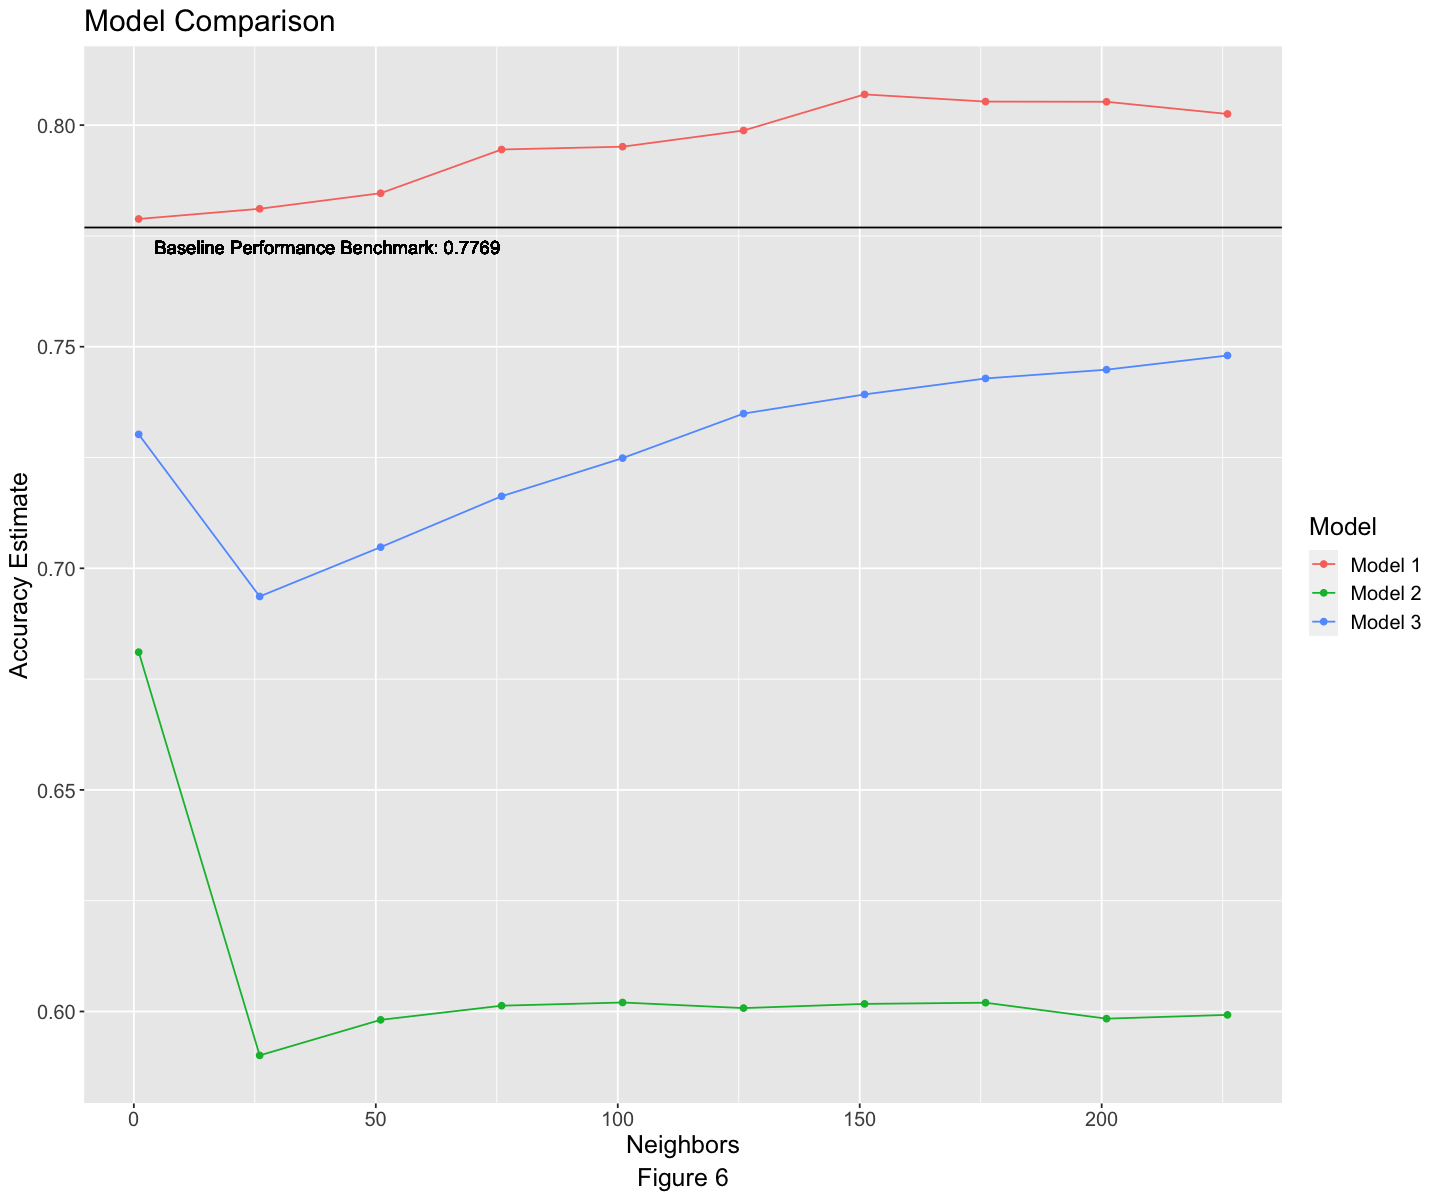

In [246]:
# Creating summary table
summary_table <- select(filter(cc_categorical_fit, .metric == "accuracy"), neighbors, mean) |>
    bind_cols(select(filter(cc_new_features_fit, .metric == "accuracy"), mean)) |>
    bind_cols(select(filter(cc_high_correlation_fit, .metric == "accuracy"), mean))

colnames(summary_table) <- c('neighbors','Model 1','Model 2','Model 3')

summary_table <- summary_table |>
    pivot_longer(cols = -neighbors,
    names_to = "grouping",
    values_to = "accuracy")

# Plotting results
options(repr.plot.width = 12, repr.plot.height = 10)
cv_vold_plot <- summary_table |>
    ggplot() +
    geom_point(aes(x = neighbors, y = accuracy, colour = grouping)) +
    geom_line(aes(x = neighbors, y = accuracy, colour = grouping)) +
    labs(x = "Neighbors", y="Accuracy Estimate", colour = "Model"
        ,caption = paste0('Figure ', figure_n <- figure_n + 1)) +
    geom_hline(yintercept = 0.7769, colour = "black") +
    geom_text(aes(40, 0.7769, label = "Baseline Performance Benchmark: 0.7769", vjust = 2))+
    ggtitle("Model Comparison") +
    scale_color_discrete(labels = c("Model 1", "Model 2", "Model 3"))+
    theme(text = element_text(size=15),
        plot.caption =  element_text(size=15,hjust=0.5))

cv_vold_plot

### 2.4 Final Model Selection and Results

In [233]:
# specify the KNN model to neighbors = 100
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 150) |> 
    set_engine("kknn") |>
    set_mode("classification")    

# fit the model
knn_final_fit <- workflow() |> 
    add_recipe(cc_categorical_recipe) |> 
    add_model(knn_spec) |> 
    fit(data = credit_card_train) #fit to the whole train data now

# test
cc_test_predictions <- predict(knn_final_fit, credit_card_test) |>
    bind_cols(credit_card_test) |>
    mutate(correct = .pred_class == y)

# regular summary
cc_test_predictions |> 
    metrics(truth = y, estimate = .pred_class) |>
    filter(.metric == "accuracy")

# confusion matrix
cc_test_predictions |>
    conf_mat(truth = y, estimate = .pred_class)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7966491


          Truth
Prediction    0    1
         0 5545 1301
         1  204  351

In [234]:
cc_test_predictions |>
    group_by(.pred_class) |>
    summarize(default_count = n()) |>
    mutate(default_pct = default_count/sum(default_count))

.pred_class,default_count,default_pct
<fct>,<int>,<dbl>
0,6846,0.92501013
1,555,0.07498987


In [235]:
credit_card_test |>
    group_by(y) |>
    summarize(default_count=n())|>
    mutate(default_pct = default_count/sum(default_count))

y,default_count,default_pct
<fct>,<int>,<dbl>
0,5749,0.7767869
1,1652,0.2232131


`summarise()` has grouped output by 'sex'. You can override using the `.groups`
argument.
`summarise()` has grouped output by 'education'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'marital_status'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'status_09'. You can override using the
`.groups` argument.


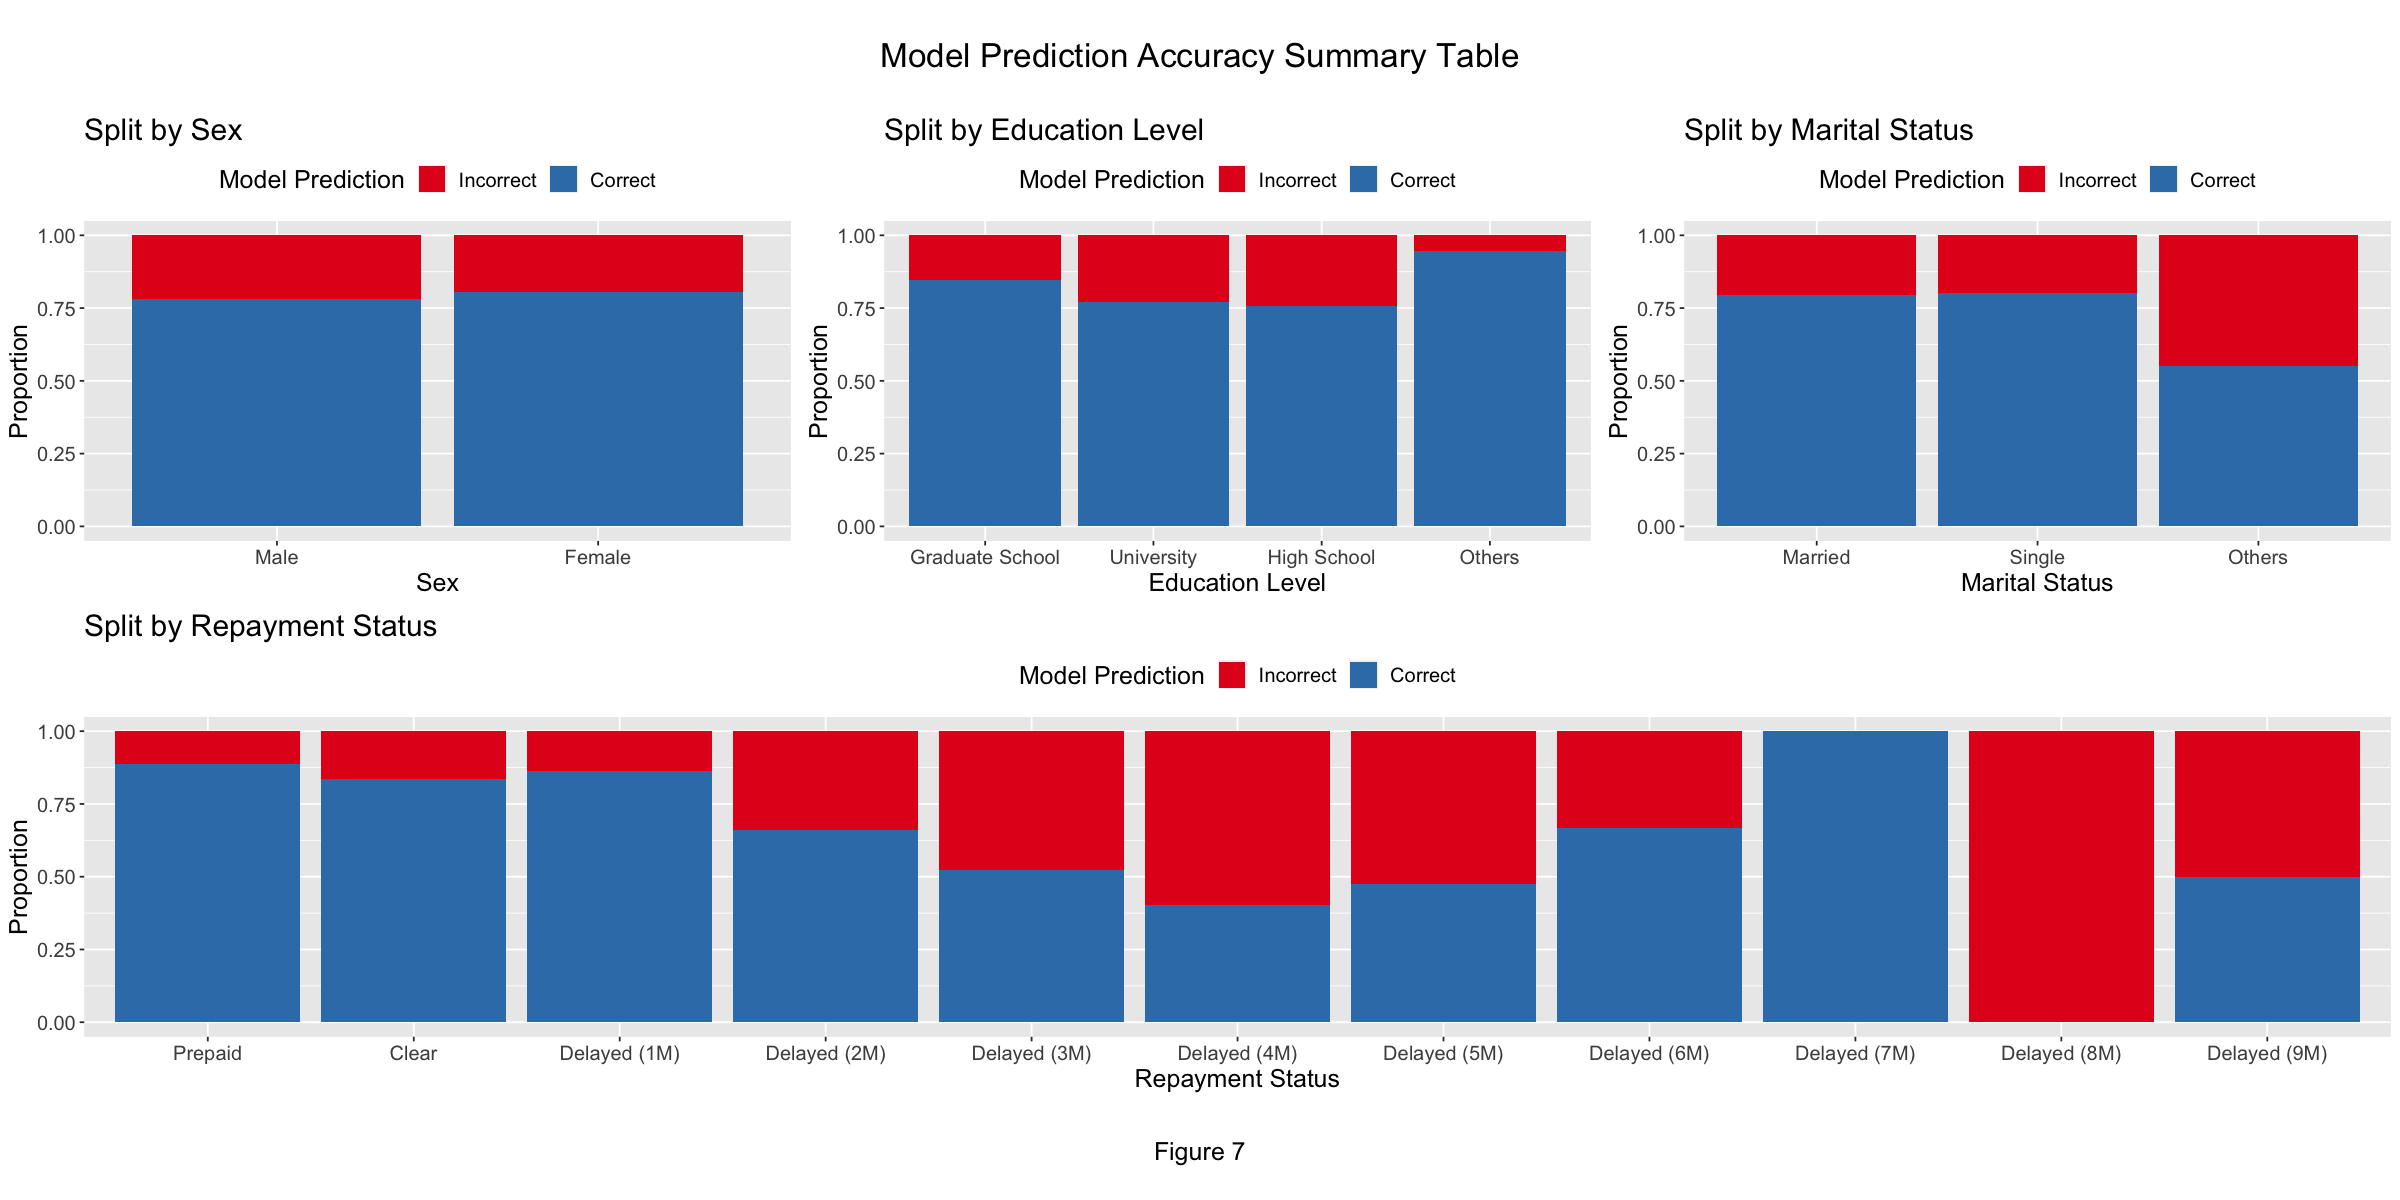

In [247]:
# Proportion of Default Status by Sex split by Education level and Marital Status
options(repr.plot.width = 20, repr.plot.height = 15) 

pl1 <- cc_test_predictions |>
    group_by(sex, correct) |>
    summarise(n=n()) |>
    ggplot(aes(x=as_factor(sex),y=n,fill=as_factor(correct))) +
    geom_bar(stat="identity",position="fill") +
    scale_fill_brewer(labels = c('Incorrect','Correct'),palette = "Set1") +
    scale_x_discrete(labels = c("1"="Male","2"="Female")) +
    labs(x = "Sex"
        ,y = "Proportion"
        ,fill = "Model Prediction"
        ,title= "Split by Sex") +
    theme(text = element_text(size=15),legend.position = "top")

pl2 <- cc_test_predictions |>
    group_by(education, correct) |>
    summarise(n=n()) |>
    ggplot(aes(x=as_factor(education),y=n,fill=as_factor(correct))) +
    geom_bar(stat="identity",position="fill") +
    scale_fill_brewer(labels = c('Incorrect','Correct'),palette = "Set1") +
    scale_x_discrete(labels = c("1"="Graduate School","2"="University","3"="High School","4"="Others")) +
    labs(x = "Education Level"
        ,y = "Proportion"
        ,fill = "Model Prediction"
        ,title= "Split by Education Level") +
    theme(text = element_text(size=15),legend.position = "top")

pl3 <- cc_test_predictions |>
    group_by(marital_status, correct) |>
    summarise(n=n()) |>
    ggplot(aes(x=as_factor(marital_status),y=n,fill=as_factor(correct))) +
    geom_bar(stat="identity",position="fill") +
    scale_fill_brewer(labels = c('Incorrect','Correct'),palette = "Set1") +
    scale_x_discrete(labels = c("1"="Married","2"="Single","3"="Others")) +
    labs(x = "Marital Status"
        ,y = "Proportion"
        ,fill = "Model Prediction"
        ,title= "Split by Marital Status") +
    theme(text = element_text(size=15),legend.position = "top")

summary_plot <- plot_grid(pl1,pl2, pl3, ncol = 3)

options(repr.plot.width = 20, repr.plot.height = 10) 

pl4 <- cc_test_predictions |>
    group_by(status_09, correct) |>
    summarise(n=n()) |>
    ggplot(aes(x=as_factor(status_09),y=n,fill=as_factor(correct))) +
    geom_bar(stat="identity",position="fill") +
    scale_fill_brewer(labels = c('Incorrect','Correct'),palette = "Set1") +
    scale_x_discrete(labels = c("-1"="Prepaid"
                                ,"0"="Clear"
                                ,"1"="Delayed (1M)"
                                ,"2"="Delayed (2M)"
                                ,"3"="Delayed (3M)"
                                ,"4"="Delayed (4M)"
                                ,"5"="Delayed (5M)"
                                ,"6"="Delayed (6M)"
                                ,"7"="Delayed (7M)"
                                ,"8"="Delayed (8M)"
                                ,"9"="Delayed (9M)")) +
    labs(x = "Repayment Status"
        ,y = "Proportion"
        ,fill = "Model Prediction"
        ,title= "Split by Repayment Status") +
    theme(text = element_text(size=15),legend.position = "top")

summary_plot <- plot_grid(summary_plot, pl4, ncol=1)

summary_title <- ggdraw() + draw_label("Model Prediction Accuracy Summary Table", size = 20)
summary_caption <- ggdraw() + draw_label(paste0('Figure ', figure_n <- figure_n + 1), size = 15)
plot_grid(summary_title, summary_plot, summary_caption, ncol=1,rel_heights=c(0.11, 1, 0.1))

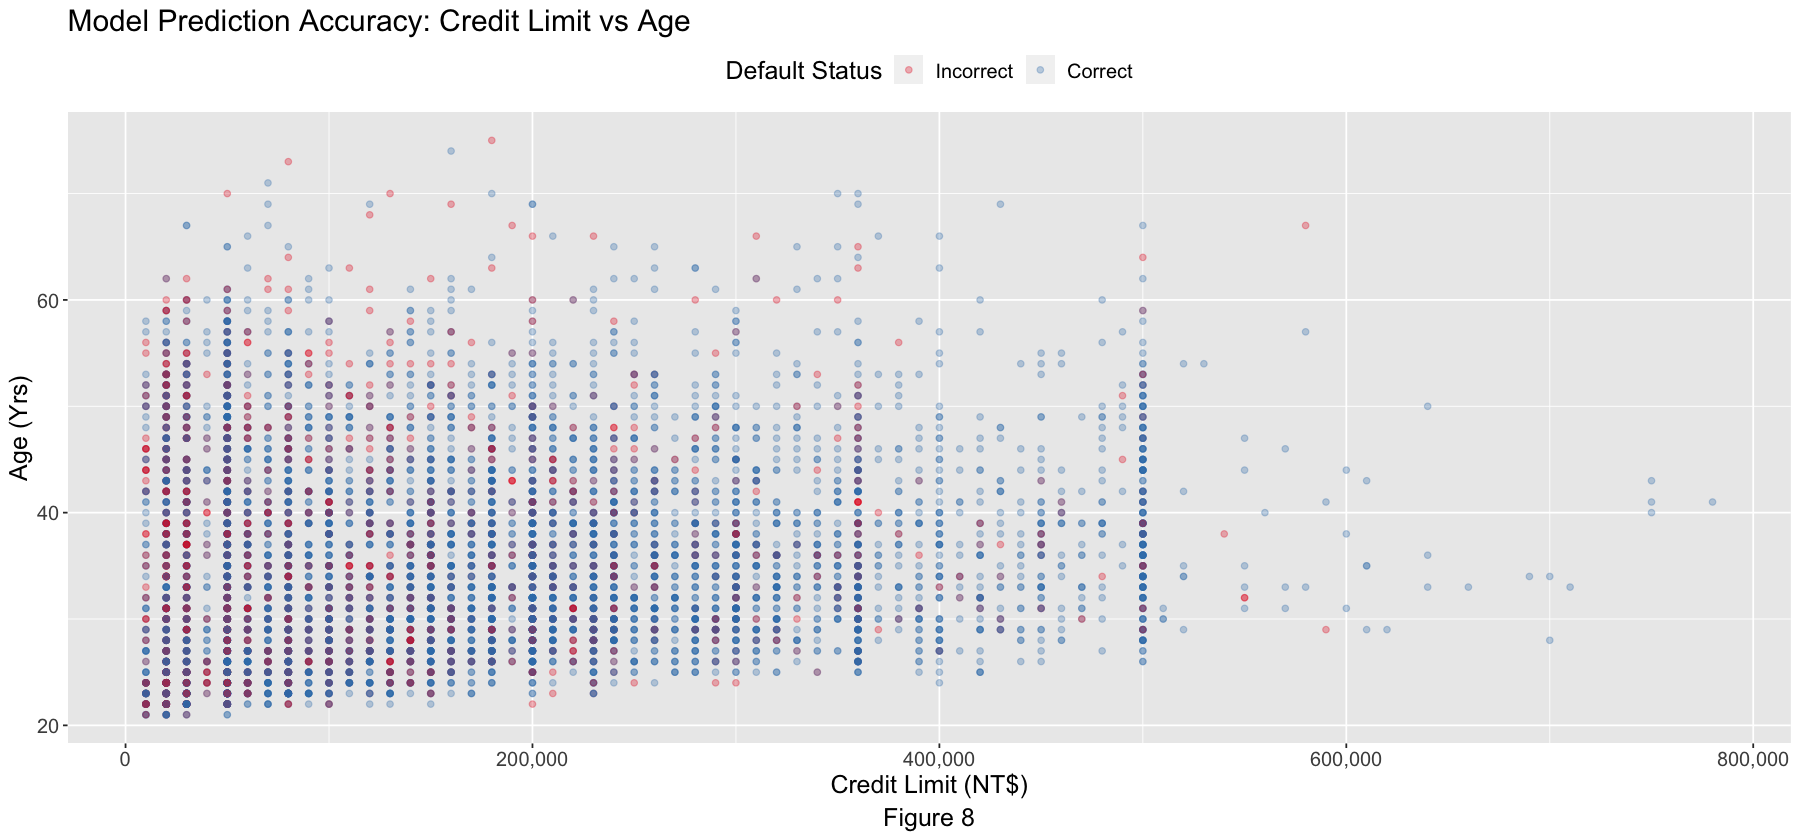

In [248]:
# Scatterplot of default status by credit limit and age
options(repr.plot.width = 15, repr.plot.height = 7) 

accuracy_age_vs_credit_limit <- cc_test_predictions |>
    ggplot(aes(x=credit_limit,y=age, color=as_factor(correct))) +
    geom_point(alpha=0.3) +
    scale_color_brewer(labels = c('Incorrect','Correct'),palette = "Set1") +
    scale_x_continuous(labels = comma) +
    labs(x="Credit Limit (NT$)"
        , y="Age (Yrs)"
        , color = "Default Status"
        , title= "Model Prediction Accuracy: Credit Limit vs Age",
        ,caption = paste0('Figure ', figure_n <- figure_n + 1)) +
    theme(text = element_text(size=15),
        legend.position = "top",
        plot.caption =  element_text(size=15,hjust=0.5))

accuracy_age_vs_credit_limit

## 3. Discussion
___

#### **3.1 Summary of Findings** #### 

After testing different values for the number of neighbours from 1 to 250, increasing in increments of 25, we found that the number of neighbours with the highest accuracy is 150 neighbours. 

We tested 3 different models, each with different predictors, to see which predictors had the largest impact on the default status of the client. 
1. **Model 1:** categorical factors (sex, marital status, education, and status_09)
2. **Model 2:** new engineered factors (balance_pct_04, and volatility)
3. **Model 3:** raw and engineered factors (all the ones mentioned above and credit limit)

By testing 3 different models, we were able to choose between them, ensuring that we get a high accuracy for our predictions. The model comparison graph shows that the model with the highest accuracy for all values of k is Model 1. Even for its worst value of k, the model’s accuracy is better than the baseline performance benchmark (the real proportion of non-default status for credit card clients), 77.69%. 

The confusion matrix shows that on our test data, our model was able to correctly predict 5545 statuses that were non-default statuses and 351 default statuses. However, it predicted that 204 statuses would default when they wouldn’t and that 1301 wouldn’t when in reality, they would default. Therefore, when the default status was default, the model correctly predicted that status only 21.25% of the time. However, when the status was not default, the model was able to correctly identify the status 96.45% of the time. 

Our model was able to correctly predict the default statuses of 79.66% of the test data, which is 1.97% higher than the baseline performance. Therefore, it is an effective model.
>
#### **3.2 Findings vs Expectation** #### 
**We expect to find varying degrees of relationship between default status and direct categorical variables.**
1. Positive relationship between default status vs education. 

    * After observing the Default Status by Sex Split by Education Level graph, we can observe that there is no relationship, all the education level groups, except for the others category, have about the same proportion of defaulted status (roughly 25%). 

2. No relationship between default status vs age, sex, and marital status.

    * **Sex**: After reviewing the Default Status by Sex Split by Marital Status plot, it was determined that men have a higher proportion that are defaulted in comparison to women, suggesting that there is a relationship.

    * **Age**: The Histogram by Default Status by Age shows the distribution of the default status of clients shows that younger clients has a higher proportion of clients that have statuses that are defaulted, which suggests that there may be a  relationship between age and default status. 

    * **Marital Status**: Marital status and default status shows no correlation/relationship, as shown in the Default Status by Sex Split by Marital Status plot. Since the proportion of defaulted statuses to non-defaulted statuses is roughly the same. 

Therefore, there is a relationship between marital status and default status of the client’s credit card, but there is a relationship between sex, age, and default status. 

#### **3.3 Impact and Further Studies** #### 
**The findings could have a broad positive impact. Specifically, it could:**
1. Create a less risky credit environment for both banks and credit card users
2. Develop educational programs for people at higher risk to minimize chance of systemic credit defaults.

**This could lead us to future questions like:**
1. What role does employment play in the default status of a credit card?


## 4. References
___

### ​References ###
* Giudici, P. (2001). Bayesian data mining, with application to benchmarking and credit scoring. Applied Stochastic Models in Business and Industry, 17(1), 69–81. https://doi.org/10.1002/asmb.425
* Lee, T.-S., Chiu, C.-C., Lu, C.-J., & Chen, I-Fei. (2002). Credit scoring using the hybrid neural discriminant technique. Expert Systems with Applications, 23(3), 245–254. https://doi.org/10.1016/s0957-4174(02)00044-1
* Yeh, I-Cheng., & Lien, C. (2009). The comparisons of data mining techniques for the predictive accuracy of probability of default of credit card clients. Expert Systems with Applications, 36(2), 2473–2480. https://doi.org/10.1016/j.eswa.2007.12.020
